In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import matplotlib.pyplot as plt
import seaborn as sns   
from torchinfo import summary

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LOAD_EDM = False

In [3]:
import torch
import dnnlib
import pickle
import pandas as pd
import numpy as np


model_root = '/workspace/localizing-edm/workdir/pretrained_models'

if LOAD_EDM:
    model_file = f'{model_root}/edm-cifar10-32x32-uncond-ve.pkl' 
else:
    model_file = f'{model_root}/baseline-cifar10-32x32-uncond-ve.pkl' 
device = torch.device('cuda')
with dnnlib.util.open_url(model_file) as f:
    net = pickle.load(f)['ema'].to(device)

net

VEPrecond(
  (model): SongUNet(
    (map_noise): FourierEmbedding()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
 

In [4]:
summary(net)

Layer (type:depth-idx)                   Param #
VEPrecond                                --
├─SongUNet: 1-1                          --
│    └─FourierEmbedding: 2-1             --
│    └─Linear: 2-2                       (131,584)
│    └─Linear: 2-3                       (262,656)
│    └─ModuleDict: 2-4                   --
│    │    └─Conv2d: 3-1                  (3,584)
│    │    └─UNetBlock: 3-2               (361,344)
│    │    └─UNetBlock: 3-3               (361,344)
│    │    └─UNetBlock: 3-4               (361,344)
│    │    └─UNetBlock: 3-5               (361,344)
│    │    └─UNetBlock: 3-6               (377,856)
│    │    └─Conv2d: 3-7                  (3,584)
│    │    └─UNetBlock: 3-8               (1,314,048)
│    │    └─UNetBlock: 3-9               (1,576,192)
│    │    └─UNetBlock: 3-10              (1,576,192)
│    │    └─UNetBlock: 3-11              (1,576,192)
│    │    └─UNetBlock: 3-12              (1,378,304)
│    │    └─Conv2d: 3-13                 (295,168)
│   

In [5]:
net.model.map_noise.freqs.shape

torch.Size([128])

In [6]:
x=torch.ones([1, net.img_channels, net.img_resolution, net.img_resolution], device=device)
t = torch.tensor([0.002], device=device)
x.shape

torch.Size([1, 3, 32, 32])

In [7]:
net = net.eval()
xhat = net(x,t)
xhat.shape

torch.Size([1, 3, 32, 32])

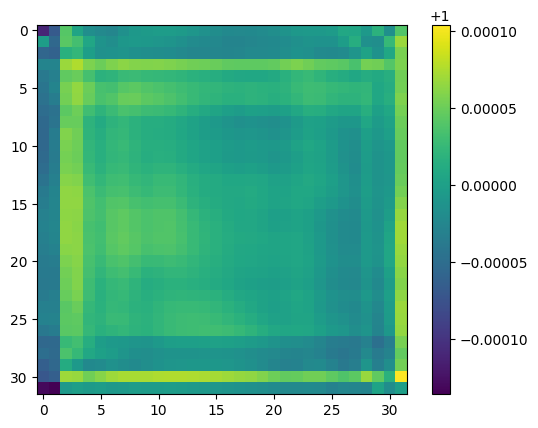

In [8]:
plt.imshow(xhat[0].permute(1,2,0).mean(-1).cpu())
plt.colorbar()

In [9]:
xhat.mean(), xhat.std()

(tensor(1.0000, device='cuda:0'), tensor(0.0002, device='cuda:0'))

In [10]:
num_steps=20
ve_sigma = lambda t: t.sqrt()
sigma_min = 0.002
sigma_max = 80
rho = 7

# Adjust noise levels based on what's supported by the network.
sigma_min = max(sigma_min, net.sigma_min)
sigma_max = min(sigma_max, net.sigma_max)

step_indices = torch.arange(num_steps, dtype=torch.float64, device="cpu")

orig_t_steps = (sigma_max ** 2) * ((sigma_min ** 2 / sigma_max ** 2) ** (step_indices / (num_steps - 1)))
sigma_steps = ve_sigma(orig_t_steps)

In [11]:
step_indices = torch.arange(num_steps, dtype=torch.float64, device="cpu")
edm_t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
edm_sigma_steps = net.round_sigma(edm_t_steps)


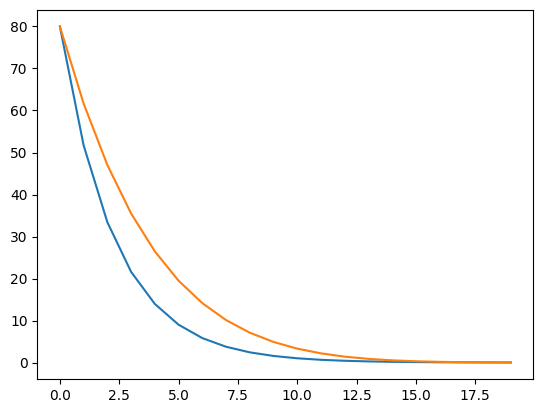

In [12]:
plt.plot(sigma_steps);
plt.plot(edm_sigma_steps);

<AxesSubplot: >

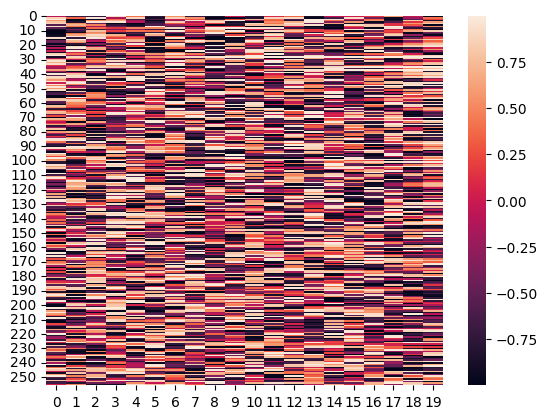

In [13]:
sns.heatmap(net.model.map_noise(sigma_steps.to(device)).T.cpu())

In [14]:
opts = dnnlib.EasyDict(
    data="workdir/datasets/cifar10-32x32.zip",
    xflip=False,
    augment=0.0,
    cond=False,
    cache=False,
    workers=1,
)

# Initialize config dict.
c = dnnlib.EasyDict()
c.dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=opts.data,
    use_labels=opts.cond,
    xflip=opts.xflip,
    cache=opts.cache,
)
c.data_loader_kwargs = dnnlib.EasyDict(
    pin_memory=True, num_workers=opts.workers, prefetch_factor=1,
    batch_size=128
)

# Validate dataset options.
dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs)
dataset_name = dataset_obj.name
c.dataset_kwargs.resolution = (
    dataset_obj.resolution
)  # be explicit about dataset resolution
c.dataset_kwargs.max_size = len(dataset_obj)  # be explicit about dataset size


In [15]:
from torch_utils import misc

seed = 42
dataset_obj = dnnlib.util.construct_class_by_name(
    **c.dataset_kwargs
)  # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(
    dataset=dataset_obj, rank=0, num_replicas=1, seed=seed
)
dataset_iterator = iter(
    torch.utils.data.DataLoader(
        dataset=dataset_obj, sampler=dataset_sampler, **c.data_loader_kwargs
    )
)

torch.Size([128, 3, 32, 32])

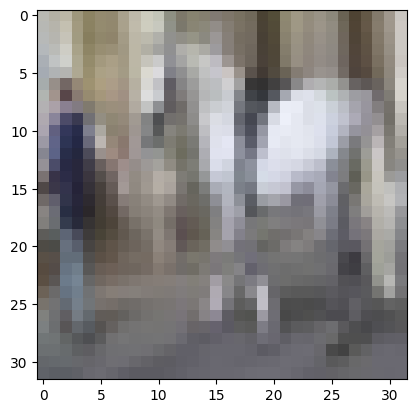

In [16]:
x_batch,_ = next(dataset_iterator)
x_batch = x_batch.to(device).to(torch.float32) / 127.5 - 1
plt.imshow((x_batch.permute(0,2,3,1)[0].cpu() + 1) / 2)
x_batch.shape

In [17]:
class OODGenerator:
    def __init__(self, iterator, patch_size=8):
        self.iterator = iterator
        self.psz = patch_size

    def __iter__(self):
        return self
    
    def __next__(self):
        x, y = next(self.iterator)
        
        # Modify the element as needed
        x = x.float()
        x[:, :, :self.psz, :self.psz] *= (1+torch.randn_like(x[:, :, :self.psz, :self.psz]))
        
        return x,y

ood_iterator = OODGenerator(dataset_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


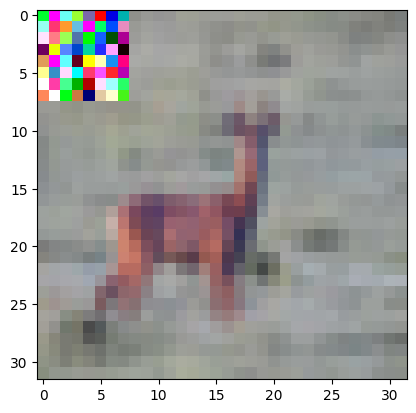

In [18]:
ood_batch,_ = next(ood_iterator)
ood_batch = ood_batch.to(device).to(torch.float32) / 127.5 - 1
plt.imshow((ood_batch.permute(0,2,3,1)[0].cpu() + 1) / 2)

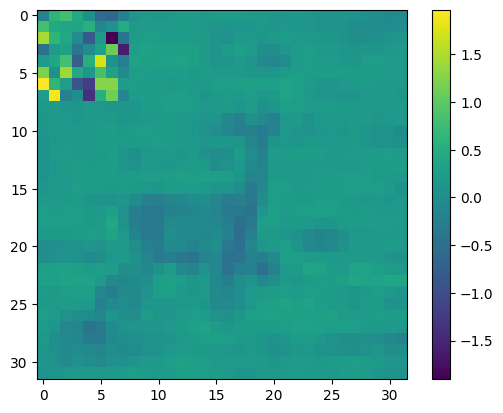

In [19]:

xhat = net(ood_batch, t)
plt.imshow(xhat[0].permute(1,2,0).mean(-1).cpu())
plt.colorbar()

In [20]:
from scorer import EDMScorer
from scorer import VEScorer

if LOAD_EDM:
    Scorer = EDMScorer
else:
    Scorer = VEScorer

score_fn = Scorer(
    net.model, sigma_min=net.sigma_min, sigma_max=net.sigma_max,
    # sigma_data=net.sigma_data, # for EDM cond
)


In [21]:
net.sigma_max, net.sigma_min

(100, 0.02)

In [22]:
score = score_fn(x_batch, torch.ones([1],device=device) * 80, debug=True)
score.shape

c_in: 1
c_noise: tensor([[[[3.6889]]]], device='cuda:0')
c_out: tensor([[[[80.]]]], device='cuda:0')


torch.Size([128, 3, 32, 32])

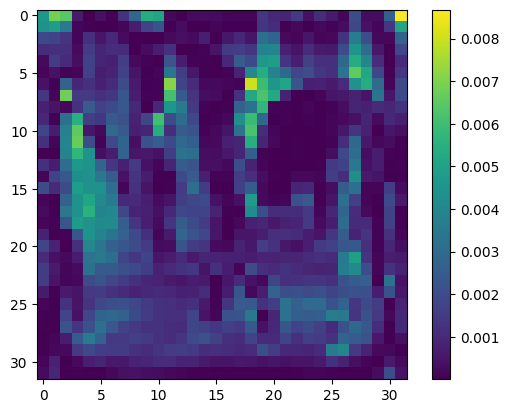

In [23]:
plt.imshow((score[0].permute(1,2,0).mean(-1).cpu())**2)
plt.colorbar()

In [24]:
from scorer import compute_scores

scores = compute_scores(
    net,
    dataset_iterator,
    sigma_max=80,
    sigma_min=0.02,
    model_type="edm" if LOAD_EDM else "ve",
)


In [25]:
score_norms = np.linalg.norm(
    scores.reshape(scores.shape[0], num_steps, -1), axis=-1
)


In [26]:
ood_scores = compute_scores(
    net,
    ood_iterator,
    sigma_max=80,
    sigma_min=0.02,
    model_type="edm" if LOAD_EDM else "ve",
)

ood_score_norms = np.linalg.norm(
    ood_scores.reshape(ood_scores.shape[0], num_steps, -1), axis=-1
)


In [27]:
recordify = lambda ds,name: [(i, sigma_steps[i].item(), x, name) for i, scores in enumerate(ds.T) for x in scores ]

records = [
    recordify(score_norms, "Train"),
    recordify(ood_score_norms, "OOD"),
]
df = pd.DataFrame.from_records(sum(records, []), columns=["t", "sigma", "score", "dataset"])
df.shape

(5120, 4)

<AxesSubplot: xlabel='t', ylabel='score'>

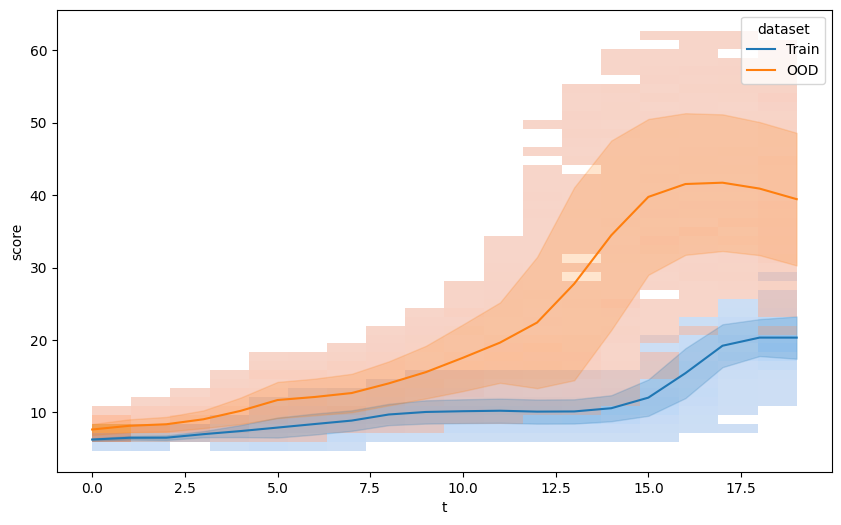

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.histplot(data=df, x="t", y="score", hue="dataset", ax=ax, alpha=0.6)
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar="sd", ax=ax)

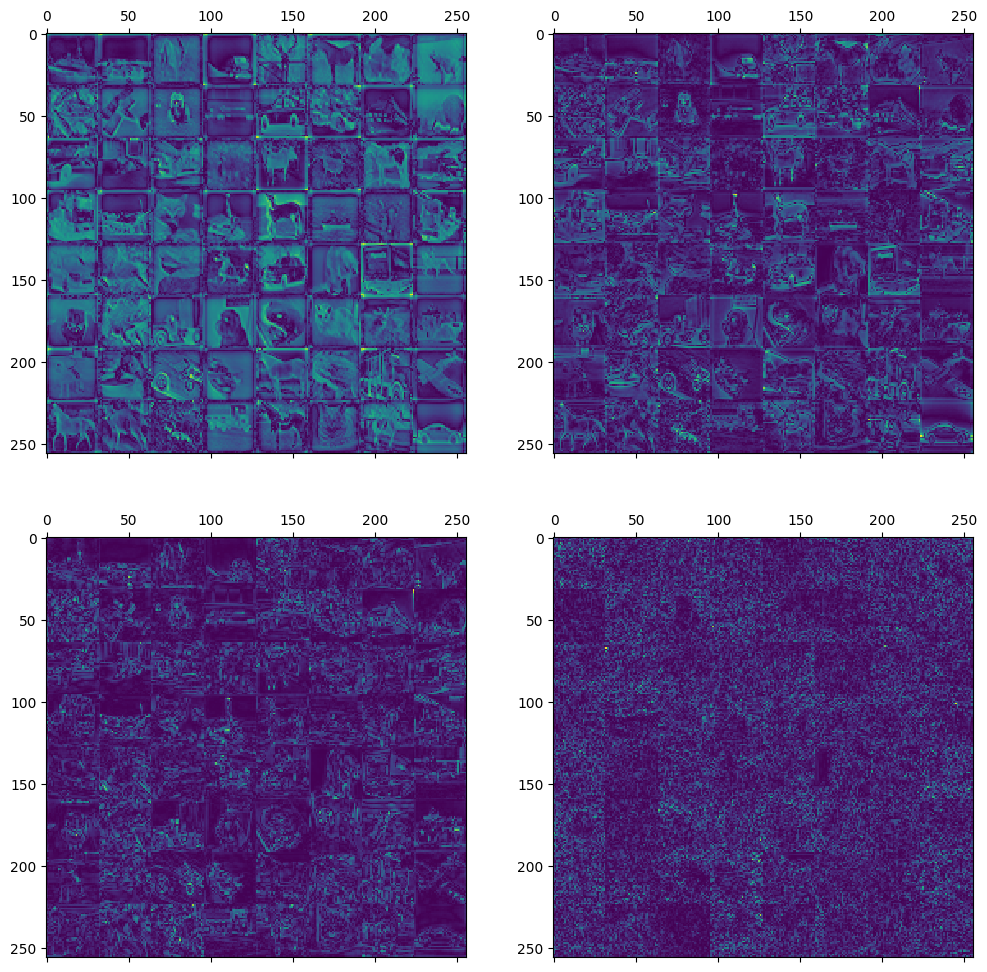

In [29]:
gridh=8
gridw=8

plot_idxs = [0, 5, 10, 19]

fig, axs = plt.subplots(2,2, figsize=(gridw*1.5, gridh*1.5))

for i, ax in zip(plot_idxs, axs.flatten()):

    image = np.abs(scores[:64, i].mean(1, keepdims=True))
    image = image.reshape(gridh, gridw, *image.shape[1:]).transpose(0, 3, 1, 4, 2)
    image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution,)
    
    ax.matshow(image)

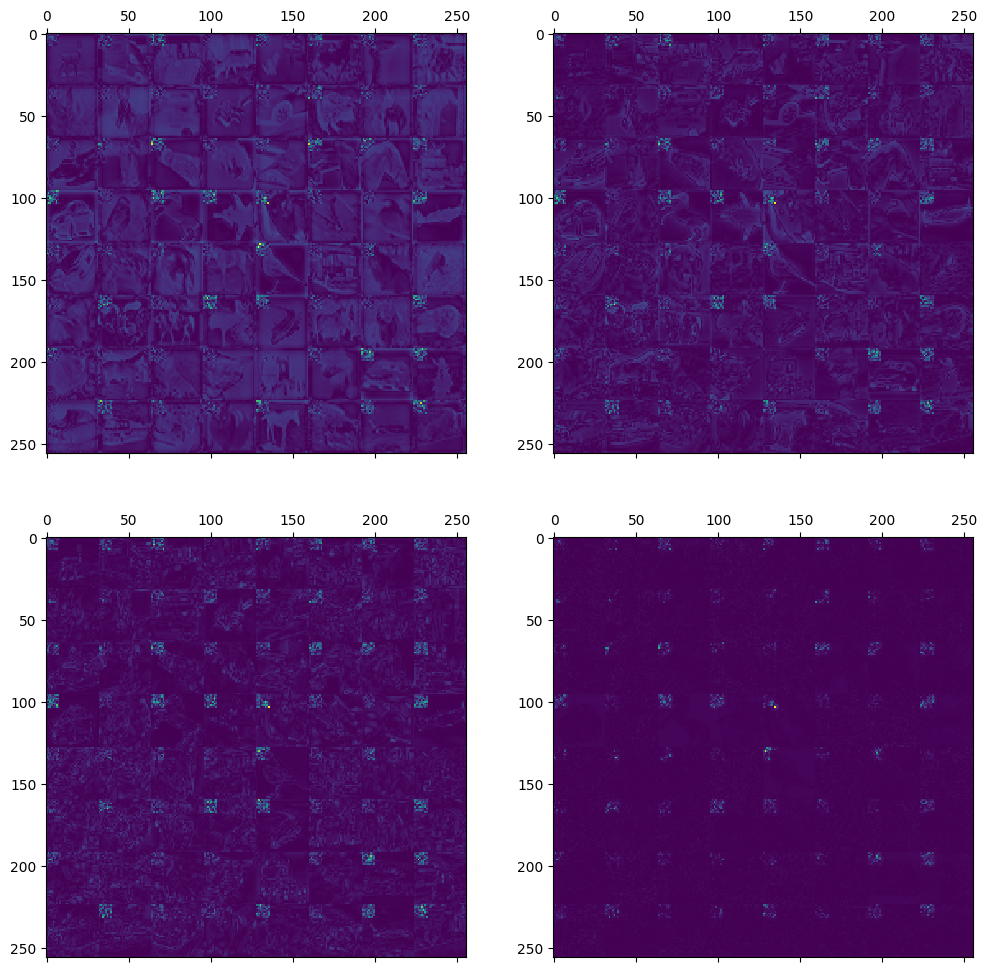

In [30]:
gridh=8
gridw=8

plot_idxs = [0, 5, 10, 19]

fig, axs = plt.subplots(2,2, figsize=(gridw*1.5, gridh*1.5))

for i, ax in zip(plot_idxs, axs.flatten()):

    image = np.abs(ood_scores[:64, i].mean(1, keepdims=True))
    image = image.reshape(gridh, gridw, *image.shape[1:]).transpose(0, 3, 1, 4, 2)
    image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution,)
    
    ax.matshow(image)

<AxesSubplot: >

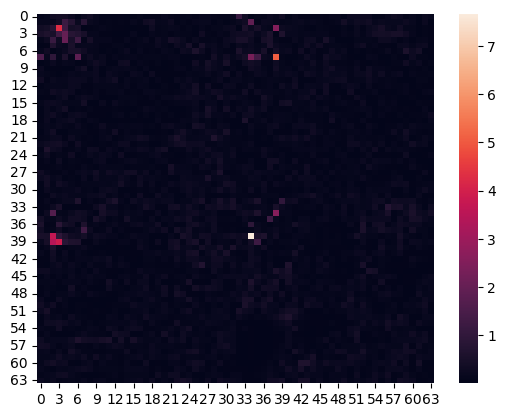

In [31]:
sns.heatmap(image[:64,:64])

In [32]:
from ood_detection_helper import auxiliary_model_analysis

X_train = score_norms[:64]
X_test = score_norms[64:]
X_ood = [ood_score_norms]

m = auxiliary_model_analysis(
        X_train,
        X_test,
        X_ood,
        components_range=range(3, 6, 1),
        labels=["Train", "Inlier", "OOD"],
        kde=True,
        verbose=0
)

m["GMM"]["metrics"]

ap      de  fpr_tpr95  fpr_tpr99  pr_auc_in  pr_auc_out  \
OOD  99.945108  1.5625        0.0      3.125  99.944892   99.791953   

       roc_auc  true_tpr95  
OOD  99.890137    92.96875

In [33]:
m["KD Tree"]["metrics"]

ap      de  fpr_tpr95  fpr_tpr99  pr_auc_in  pr_auc_out  \
OOD  99.950966  1.5625        0.0     1.5625  99.950772   99.816648   

       roc_auc  true_tpr95  
OOD  99.902344    92.96875

In [34]:
m["KDE"]["metrics"]

ap       de  fpr_tpr95  fpr_tpr99  pr_auc_in  pr_auc_out  \
OOD  99.962938  0.78125        0.0     1.5625   99.96279   99.865101   

       roc_auc  true_tpr95  
OOD  99.926758    92.96875